torch.Size([60000, 28, 28])
torch.Size([60000])


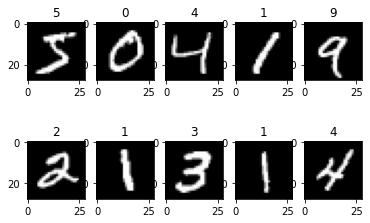

LeNet(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)
Epoch:  0 | loss: 2.3027 | test accuracy: 0.10
Epoch:  0 | loss: 0.3876 | test accuracy: 0.83
Epoch:  0 | loss: 0.4331 | test accuracy: 0.89
Epoch:  0 | loss: 0.1934 | test accuracy: 0.91
Epoch:  0 | loss: 0.2204 | test accuracy: 0.92
Epoch:  0 | loss: 0.1448 | test accuracy: 0.94
Epoch:  0 | loss: 0.3246 | test accuracy: 0.95
Epoch:  0 | loss: 0.2101 | test accuracy: 0.95

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt

EPOCH = 1               # train the training data n times, to save time, we just train 1 epoch
BATCH_SIZE = 50
LR = 0.001              # learning rate
DOWNLOAD_MNIST = True   # set to False if you have downloaded

# Mnist digits dataset
train_data = torchvision.datasets.MNIST(
    root='./mnist/',
    train=True,                                     # this is training data
    transform=torchvision.transforms.ToTensor(),    # Converts a PIL.Image or numpy.ndarray to
                                                    # torch.FloatTensor of shape (C x H x W) and normalize in the range [0.0, 1.0]
    download=DOWNLOAD_MNIST,                        # download it if you don't have it
)

# plot one example
print(train_data.data.size())                 # (60000, 28, 28)
print(train_data.targets.size())               # (60000)

for ind in range(10):
    plt.subplot(2, 5, ind+1)
    plt.imshow(train_data.data[ind].numpy(), cmap='gray')
    plt.title('%i' % train_data.targets[ind])
plt.show()

train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

# convert test data into Variable, pick 2000 samples to speed up testing
test_data = torchvision.datasets.MNIST(root='./mnist/', train=False)
#shape from (2000, 28, 28) to (2000, 1, 28, 28)
test_x = torch.unsqueeze(test_data.data, dim=1).type(torch.FloatTensor)[:2000]
test_y = test_data.targets[:2000]

    
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1,
                      out_channels=6,
                      kernel_size=5,
                      stride=1,
                      padding=2), # 6*28*28
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2) # 6*14*14
        )
        
        self.conv2 = nn.Sequential( 
            nn.Conv2d(in_channels=6,
                      out_channels=16,
                      kernel_size=5,
                      stride=1,
                      padding=0), # 16*10*10
            nn.ReLU(True), 
            nn.MaxPool2d(kernel_size=2) # 16*5*5
        )

        self.fc = nn.Sequential(
            nn.Linear(16*5*5, 120), 
            nn.Linear(120, 84), 
            nn.Linear(84, 10)
        )

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

cnn = LeNet()
print(cnn)  # net architecture
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()                       # the target label is not one-hotted

# training
for epoch in range(EPOCH):
    for step, (b_x, b_y) in enumerate(train_loader):   # gives batch data, normalize x when iterate train_loader
        output = cnn(b_x)               # cnn output
        loss = loss_func(output, b_y)   # cross entropy loss
        optimizer.zero_grad()           # clear gradients for this training step
        loss.backward()                 # backpropagation, compute gradients
        optimizer.step()                # apply gradients

        if step % 64 == 0:
            test_output = cnn(test_x)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)
            
# print 10 predictions from test data
test_output = cnn(test_x[:10])

pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print("testing")
for ind in range(10):
    plt.subplot(2, 5, ind+1)
    plt.imshow(test_data.data[ind].numpy(), cmap='gray')
    plt.title('%i->%i' % (pred_y[ind], test_y[ind].data))
plt.show()
